In [1]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
DATA_DIR = f'{ROOT_DIR}/data/Heart'

In [420]:
import pandas as pd
import numpy as np
import copy
import sys
sys.path.append(f'{ROOT_DIR}/code/helper/')
import OTCost as ot
import importlib
importlib.reload(ot)
import random
from sklearn.preprocessing import MinMaxScaler
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

## Load data

In [546]:
##load datasets
columns = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'sugar', 'ecg', 'max_hr', 'exercise_angina', 'exercise_ST_depression', 'slope_ST', 'number_major_vessels', 'thalassemia_hx', 'target']
used_columns =  ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'sugar', 'ecg', 'max_hr', 'exercise_angina', 'exercise_ST_depression', 'target']
cleveland = pd.read_csv(f'{DATA_DIR}/processed.cleveland.data', names = columns, na_values='?', usecols = used_columns).dropna()
hungary = pd.read_csv(f'{DATA_DIR}/processed.hungarian.data', names = columns, na_values='?', usecols = used_columns).dropna()
swiss = pd.read_csv(f'{DATA_DIR}/processed.switzerland.data', names = columns, na_values='?', usecols = used_columns).dropna()
va = pd.read_csv(f'{DATA_DIR}/processed.va.data', names = columns, na_values='?', usecols = used_columns).dropna()

In [419]:
datasets = {
    "cleveland": cleveland,
    "hungary": hungary,
    "swiss": swiss,
    "va": va
}

In [315]:
##sizes
cleveland.shape[0], hungary.shape[0], swiss.shape[0], va.shape[0]

(303, 261, 46, 130)

# Visualise data

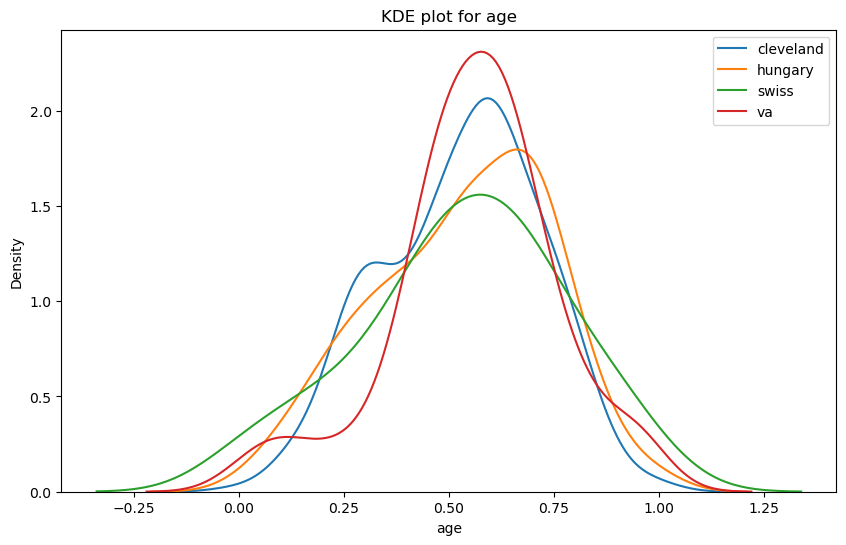

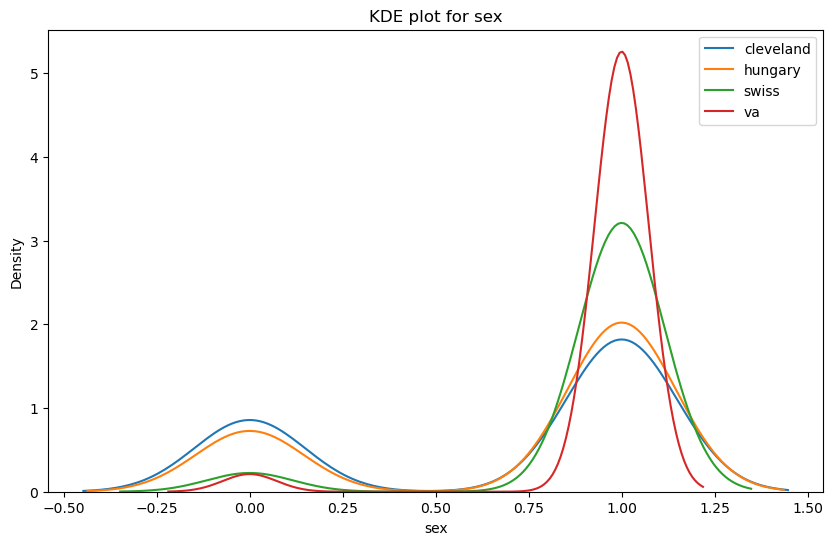

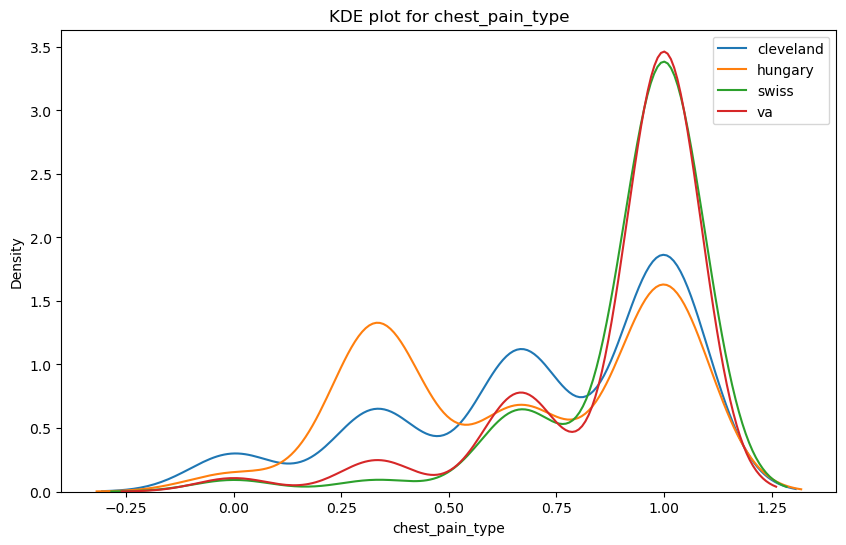

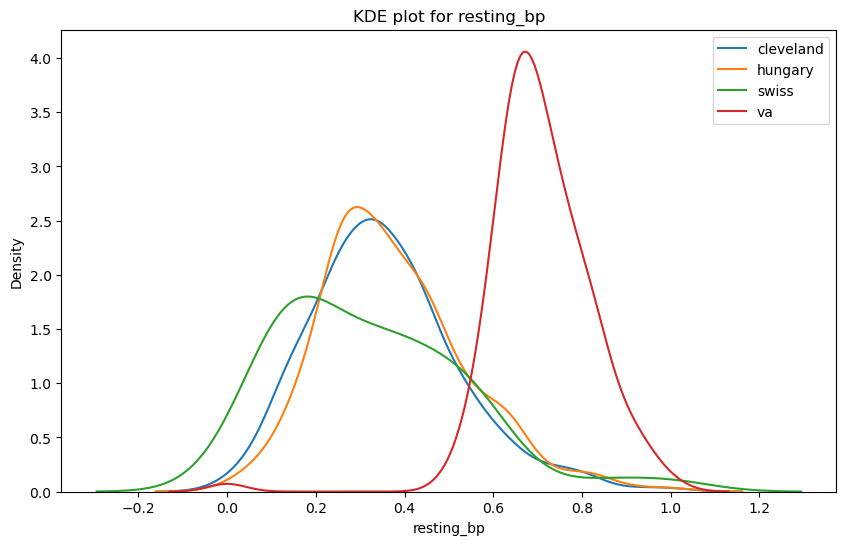

/tmp/ipykernel_16170/1545721187.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(dataset[feature], label=name)


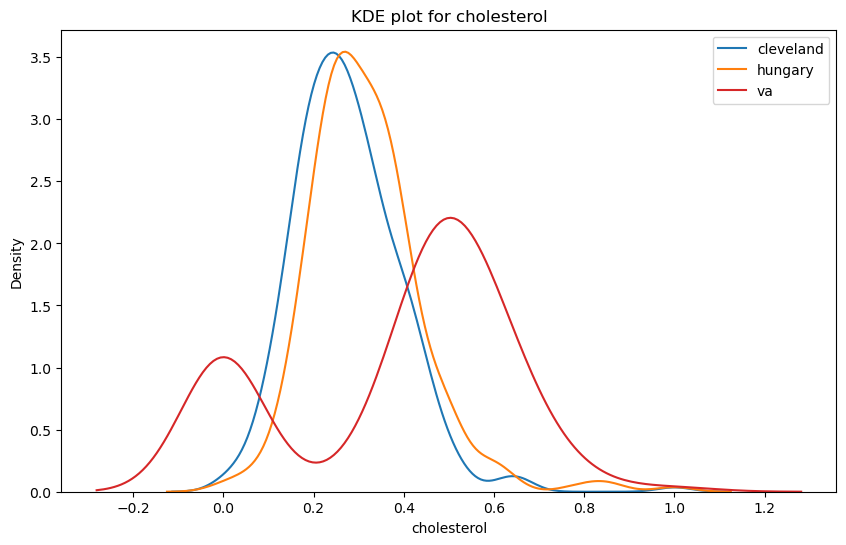

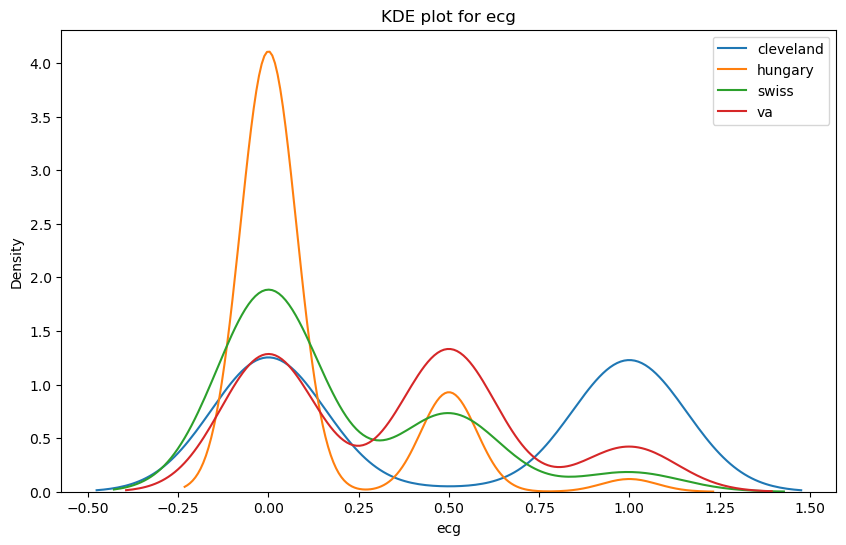

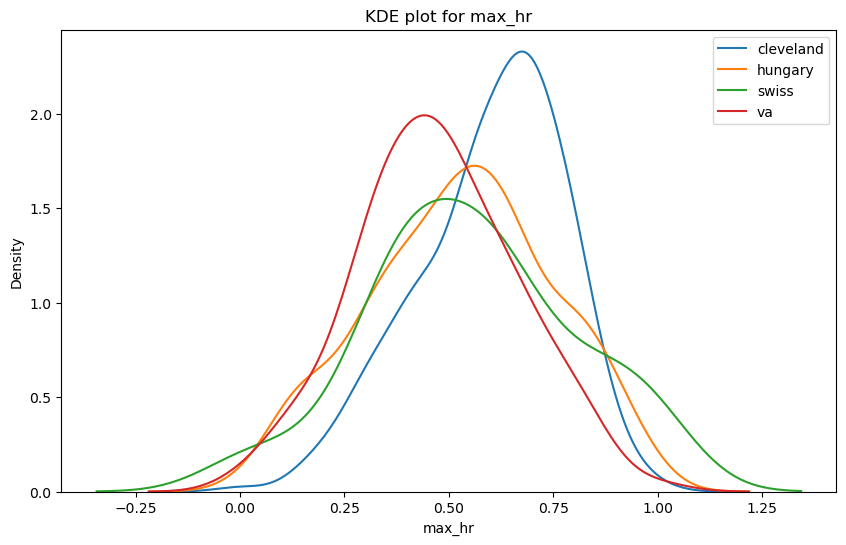

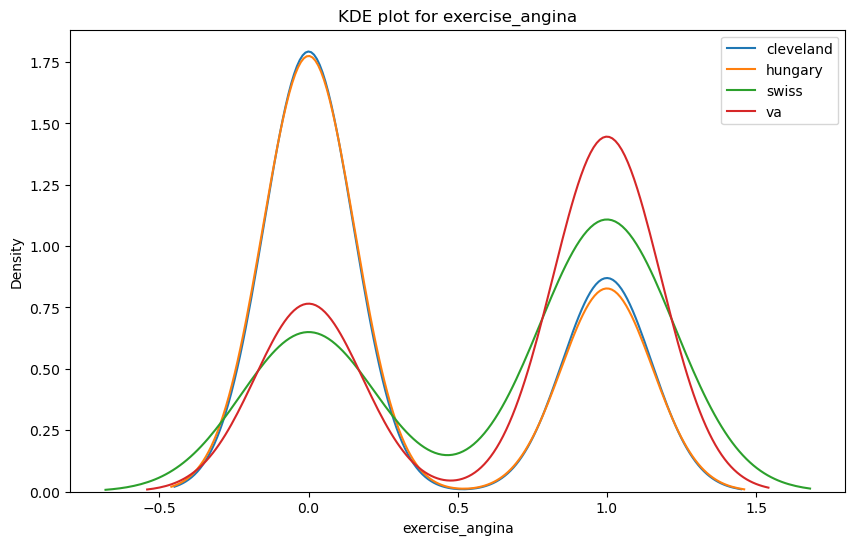

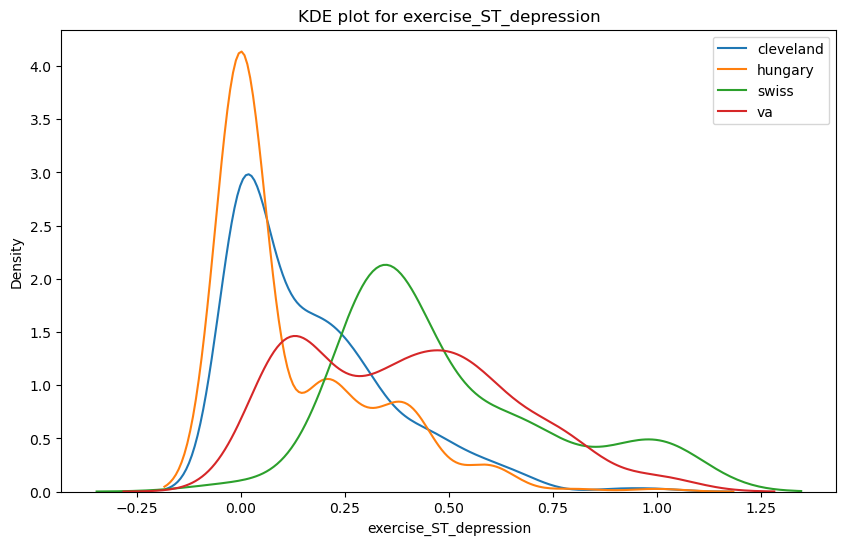

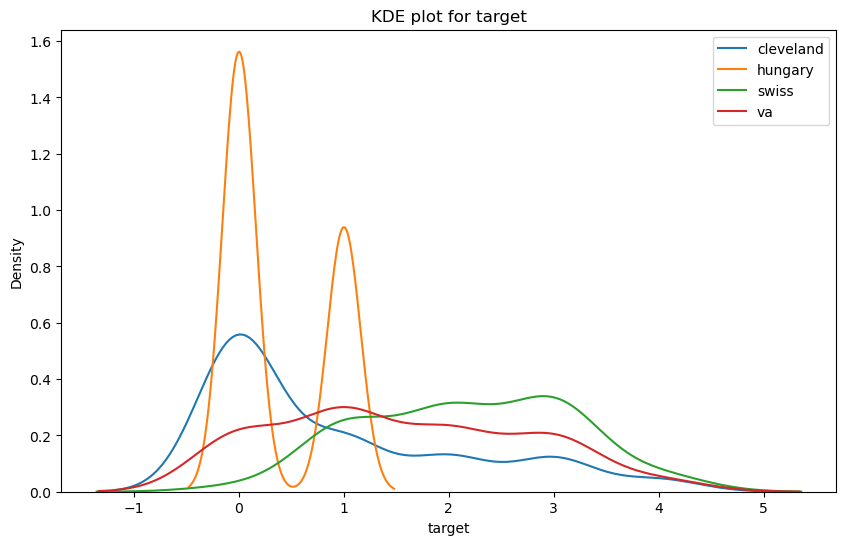

In [87]:
features = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'ecg', 'max_hr', 'exercise_angina', 'exercise_ST_depression', 'target']

for feature in features:
    plt.figure(figsize=(10, 6))
    for name, dataset in datasets.items():
        sns.kdeplot(dataset[feature], label=name)
    plt.title(f'KDE plot for {feature}')
    plt.legend()
    plt.show()

# Process data

In [583]:
def prep_data(df_1, df_2, single):
    #scale data using 1 site as reference
    df_1_sc = copy.deepcopy(df_1)
    df_2_sc = copy.deepcopy(df_2)
    if single:
        half_len = len(df_1_sc) // 2
        df_2_sc = df_1_sc.iloc[half_len:]
        df_1_sc = df_1_sc.iloc[:half_len]
    cols_to_scale = ['age', 'chest_pain_type', 'resting_bp', 'cholesterol', 'ecg', 'max_hr',  'exercise_ST_depression']
    scaler = MinMaxScaler()
    df_1_sc[cols_to_scale] = scaler.fit_transform(df_1_sc[cols_to_scale])
    df_2_sc[cols_to_scale] = scaler.transform(df_2_sc[cols_to_scale])
    #filter calculation only labels with 10+ occurrecnes
    df_1_sc = df_1_sc.groupby('target').filter(lambda x: len(x) > 5)
    df_2_sc = df_2_sc.groupby('target').filter(lambda x: len(x) > 5)
    #create dictionaries
    X1, y1 = df_1_sc.iloc[:,:-1].values, df_1_sc.iloc[:,-1].values 
    X2, y2 = df_2_sc.iloc[:,:-1].values, df_2_sc.iloc[:,-1].values 
    return {"1":X1, "2": X2}, {"1":y1, "2":y2}

In [487]:
def saveDataset(X,y, name):
    d1= np.concatenate((X, y.reshape(-1,1)), axis=1)
    np.savetxt(f'{DATA_DIR}/{name}.csv',d1)
    return

## OT cost

In [549]:
sites = ['cleveland', 'hungary', 'va', 'swiss']
site_comb = list(itertools.product(sites, repeat=2))

In [550]:
private = False
DATASET = 'Heart'
SAVE = False

In [584]:
importlib.reload(ot)
ot_cost_sites = {}
for comb in site_comb:
    if comb[0] == comb[1]:
        single = True
    else:
        single = False
    data, label = prep_data(datasets[comb[0]], datasets[comb[1]], single)
    Heart_OTCost_label = ot.OTCost(DATASET, data, label)
    try:
        cost = Heart_OTCost_label.calculate_ot_cost()
        cost = "{:.2f}".format(float(cost))
    except:
        cost = np.nan
    ot_cost_sites[comb] = cost
if SAVE:
    saveDataset(data['1'],label['1'], f'data_1_{cost}')
    saveDataset(data['2'],label['2'], f'data_2_{cost}')

cost: 0.05
cost: 0.08
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Assigned average value
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Assigned average value
cost: 0.16
cost: 0.31
cost: 0.09
cost: 0.15
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Assigned average value
cost: 0.19
cost: 0.36
cost: 0.12
cost: 0.16
cost: 0.07
cost: 0.13
cost: 0.40
cost: 0.39
cost: 0.31
cost: 0.15


In [588]:
costs_series = pd.Series(ot_cost_sites)
costs_df = costs_series.unstack()
mask = np.triu(np.ones_like(costs_df, dtype=bool))
costs_df.where(mask)

,cleveland,hungary,swiss,va
cleveland,0.05,0.08,0.31,0.16
hungary,NaN,0.15,0.36,0.19
swiss,NaN,NaN,0.15,0.31
va,NaN,NaN,NaN,0.07


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [646]:
def process_data(df_1, df_2, single):
    cols_to_scale = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol', 'ecg', 'max_hr', 'exercise_ST_depression']
    scaler = MinMaxScaler()
    df_1_train, df_1_test = train_test_split(df_1, test_size=0.3, random_state=42)
    df_1_train[cols_to_scale] = scaler.fit_transform(df_1_train[cols_to_scale])
    df_1_test[cols_to_scale] = scaler.transform(df_1_test[cols_to_scale])
    df_2[cols_to_scale] = scaler.transform(df_2[cols_to_scale])
    if single:
        df_train = df_1_train
        df_test = df_1_test
    else:
        df_train = pd.concat([df_1_train,df_2])
        df_test = pd.concat([df_1_test,df_2])
    return df_train, df_test

In [637]:
def run_model(df_1, df_2, single = False):
    df_1_sc = copy.deepcopy(df_1)
    df_2_sc = copy.deepcopy(df_2)
    df_train, df_test = process_data(df_1_sc, df_2_sc, single)
    X_train= df_train.drop('target', axis=1)
    y_train = df_train['target']
    X_test= df_test.drop('target', axis=1)
    y_test = df_test['target']
    #split only the 
    clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    val_accuracy = accuracy_score(y_train, y_train_pred)
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    return val_accuracy, test_accuracy

In [645]:
perf_sites = {}
for comb in site_comb:
    if comb[0] == comb[1]:
        single = True
    else:
        single = False
    val_acc, test_acc = run_model(datasets[comb[0]], datasets[comb[1]], single)
    perf_sites[comb] = test_acc

perf_series = pd.Series(perf_sites)
perf_df = perf_series.unstack()
mask = np.triu(np.ones_like(perf_df, dtype=bool))
perf_df.where(mask)

,cleveland,hungary,swiss,va
cleveland,0.56044,0.688235,0.466667,0.469231
hungary,NaN,0.783439,0.752688,0.584746
swiss,NaN,NaN,0.500000,0.188679
va,NaN,NaN,NaN,0.320513
